In [429]:
#import libraries

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.externals.six import StringIO

%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [430]:
#import data from crash_summary.csv 
crash_data = pd.read_csv("ct_bike_crash_data/crash_summary.csv")

#cleanup field headers
crash_data.columns = crash_data.columns.str.replace('\s+', '_')

#drop unnecessary fields
crash_data.drop(['Severity',
                 'DOT_Case_Number',
                 'Severity', 
                 'Severity_Text_Format', 
                 'Most_Severe_Injury',
                 'Number_Of_Pedestrians',
                 'Number_Of_Qualifying_Commercial_Vehicles',
                 'Town',
                 'Town_Text_Format',
                 'Route_Class',
                 'Route_or_Local_Road_Number',
                 'Route_Direction',
                 'Cumulative_Route_Mileage',
                 'Ramp_or_Turning_Road_Number',
                 'Ramp_Letter',
                 'At_or_Between_Intersections',
                 'Intersecting_Leg_#1',
                 'Intersecting_Leg_#2',
                 'Intersecting_Leg_#3',
                 'Intersecting_Leg_#4',
                 'Name_of_Road_that_Crash_Occurred_On',
                 'Name_or_Route_Number_of_Road_at_which_Crash_Occurred',
                 'Measure_Distance',
                 'Unit_Of_Measure',
                 'Unit_Of_Measure_Text_Format',
                 'Measure_Direction',
                 'Measure_Direction_Text_Format',
                 'Name_of_Nearest_Intersection,_Street,_Town_Line_or_Mile_Marker',
                 'Alpha_Description_of_Crash_Location',
                 'Collision_Type',
                 'Collision_Type_Text_Format',
                 'Weather_Condition',
                 'Road_Surface_Condition',
                 'Light_Condition',
                 'Crash_Occurred_On',
                 'Crash_Occurred_On_Text_Format',
                 'Other_Roadway_Feature',
                 'Other_Roadway_Feature_Text_Format',
                 'Median_Barrier_Penetration',
                 'Median_Barrier_Penetration_Text_Format',
                 'Construction_or_Maintenance_Related',
                 'At-Fault_Traffic_Unit_Number',
                 'Contributing_Factor',
                 'Contributing_Factor_Text_Format',
                 'Average_Daily_Traffic',
                 'Rural_or_Urban',
                 'Rural_or_Urban_Text_Format',
                 'Number_of_Lanes',
                 'Route_Direction'],
                 axis=1, inplace=True)

#cleanup field headers again
crash_data.columns = crash_data.columns.str.replace('_Text_Format', '')

#do some datetime stuff to get hour and DOW
crash_data['Crash_Date_Time'] = crash_data.apply(lambda x: x['Date_Of_Crash'] + ' ' + x['Time_Of_Crash'] , axis = 1)
crash_data.Crash_Date_Time = pd.to_datetime(crash_data.Crash_Date_Time,format="%m/%d/%Y %H:%M:%S")
del crash_data['Date_Of_Crash']
del crash_data['Time_Of_Crash']
crash_data['Crash_DOW'] = crash_data.Crash_Date_Time.dt.weekday_name
crash_data['Crash_Hour'] = crash_data.Crash_Date_Time.dt.hour
del crash_data['Crash_Date_Time']


#going to create dummies for all of these categorical variables
for i in range(3,11):
    if crash_data.columns[i] == 'Construction_or_Maintenance_Related':
        dummies = pd.get_dummies(crash_data.iloc[:,i], drop_first=True, prefix = 'Const').astype(int)
    else:
        dummies = pd.get_dummies(crash_data.iloc[:,i], drop_first=False).astype(int)
    crash_data = pd.concat([crash_data,dummies],axis=1)
    
for i in range(3,11):
    crash_data.drop(crash_data.columns[3],inplace=True, axis=1)

#get rid of unknown dummy variables
crash_data.drop('Unknown', axis=1, inplace=True)
crash_data.drop('Other', axis=1, inplace=True)

#set injury level to int value
def injury_value(x):
    if x == 'Not Injured':
        return 0
    elif x == 'Possible Injury (Claim of Non-Evident Injury)':
        return 1
    elif x == 'Non Incapacitating Evident Injury':
        return 2
    elif x == 'Incapacitating Injury (Prevents Return to Normal Activity)':
        return 3
    elif x == 'Fatal Injury':
        return 4 
crash_data['Injury_Level'] = crash_data.apply(lambda x: injury_value(x['Most_Severe_Injury']), axis = 1)
del crash_data['Most_Severe_Injury']


In [431]:
#import data from person_summary.csv
person_data = pd.read_csv("ct_bike_crash_data/person_summary.csv")

#cleanup field headers
person_data.columns = person_data.columns.str.replace('\s+', '_')

#new DF with fields we want
new_person_data = person_data.filter(['Crash_ID',
                                      'Involved_Person_Age',
                                      'Occupant_Protection_System_Use_Text_Format'],
                                      axis=1)

#cleanup field headers again
new_person_data.columns = new_person_data.columns.str.replace('_Text_Format', '')

#wearing helmet? - create dummy
def helmet_convert(x):
    if x == 'Helmet/High Visibility Clothing' or x == 'Helmet/No High Visibility Clothing':
        return 1
    else:
        return 0
new_person_data['Helmet'] = new_person_data.apply(lambda x: helmet_convert(x['Occupant_Protection_System_Use']),
                                                  axis = 1)

#wearing high-vis? - create dummy 
def high_vis_convert(x):
    if x == 'Helmet/High Visibility Clothing' or x == 'No Helmet/High Visibility Clothing':
        return 1
    else:
        return 0    
new_person_data['High_Vis'] = new_person_data.apply(lambda x: high_vis_convert(x['Occupant_Protection_System_Use']), 
                                                  axis = 1)
#delete categorical column
del new_person_data['Occupant_Protection_System_Use']


new_person_data['Involved_Person_Age'] = new_person_data['Involved_Person_Age'].fillna(0.0).astype(int)

In [432]:
#import_data from traffic_unit_summary.csv
tus_data = pd.read_csv("ct_bike_crash_data/traffic_unit_summary.csv")

#cleanup_headers
tus_data.columns = tus_data.columns.str.replace('\s+', '_')

new_tus_data = tus_data.filter(['Crash_ID',
                                    'Vehicle_Operator_or_Pedestrian_Sex_Text_Format',
                                    'Vehicle_Operator_or_Pedestrian_Alcohol_or_Drugs_Code_Text_Format'],
                                    axis=1)

#cleanup field headers again
new_tus_data.columns = new_tus_data.columns.str.replace('_Text_Format', '')

#cleanup Alcohol/Drugs code
def under_influence_convert(x):
    if x == 'No indication or unknown':
        return 0
    else:
        return 1
new_tus_data['Under_Influence'] = new_tus_data.apply(lambda x: under_influence_convert(
                                                x['Vehicle_Operator_or_Pedestrian_Alcohol_or_Drugs_Code']),
                                                axis = 1)

#create dummies for sex
dummies = pd.get_dummies(new_tus_data.iloc[:,1], drop_first=False).astype(int)
new_tus_data = pd.concat([new_tus_data,dummies],axis=1)

new_tus_data.drop(['Vehicle_Operator_or_Pedestrian_Sex',
                 'Vehicle_Operator_or_Pedestrian_Alcohol_or_Drugs_Code',
                 'Driverless Vehicle',
                 'Sex Unknown'],
                 axis=1, inplace=True)

In [433]:
#merge our data and reorganize
all_crash_data = pd.merge(crash_data, new_person_data, on='Crash_ID', how='inner')
all_crash_data = pd.merge(all_crash_data, new_tus_data, on='Crash_ID', how='inner')

all_crash_columns = all_crash_data.columns.tolist()
all_crash_columns = all_crash_columns[:38]+all_crash_columns[39:]+all_crash_columns[38:39]

all_crash_data = all_crash_data[all_crash_columns]
      

In [436]:
#lets create a scatter matrix to check out the data

X,y = all_crash_data.iloc[:,1:43],all_crash_data.iloc[:,-1]
feature_names= X.columns.tolist()
target_name = all_crash_data.columns.tolist()[-1]

#sns.pairplot(all_crash_data[feature_names])

In [413]:
X,y = all_crash_data.iloc[:,1:43],all_crash_data.iloc[:,-1]
feature_names= X.columns.tolist()
target_name = all_crash_data.columns.tolist()[-1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.4,random_state=20)

decision_tree = DecisionTreeRegressor(max_depth=1, min_samples_split = 10)
decision_tree.fit(X_train,y_train)
print("Decision Tree RMSE:",np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test))))

Decision Tree RMSE: 0.845730541576


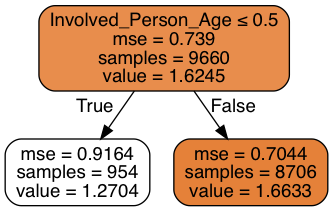

In [414]:
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

In [415]:
#lets try it without unknown age
all_crash_data_known_age = all_crash_data[all_crash_data.Involved_Person_Age != 0]


In [422]:
X,y = all_crash_data_known_age.iloc[:,1:43],all_crash_data_known_age.iloc[:,-1]
feature_names= X.columns.tolist()
target_name = all_crash_data_known_age.columns.tolist()[-1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.4,random_state=20)

decision_tree = DecisionTreeRegressor(max_depth=4, min_samples_split = 10)
decision_tree.fit(X_train,y_train)
print("Decision Tree RMSE:",np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test))))

Decision Tree RMSE: 0.834144037183


ValueError: Can't handle mix of multiclass and continuous

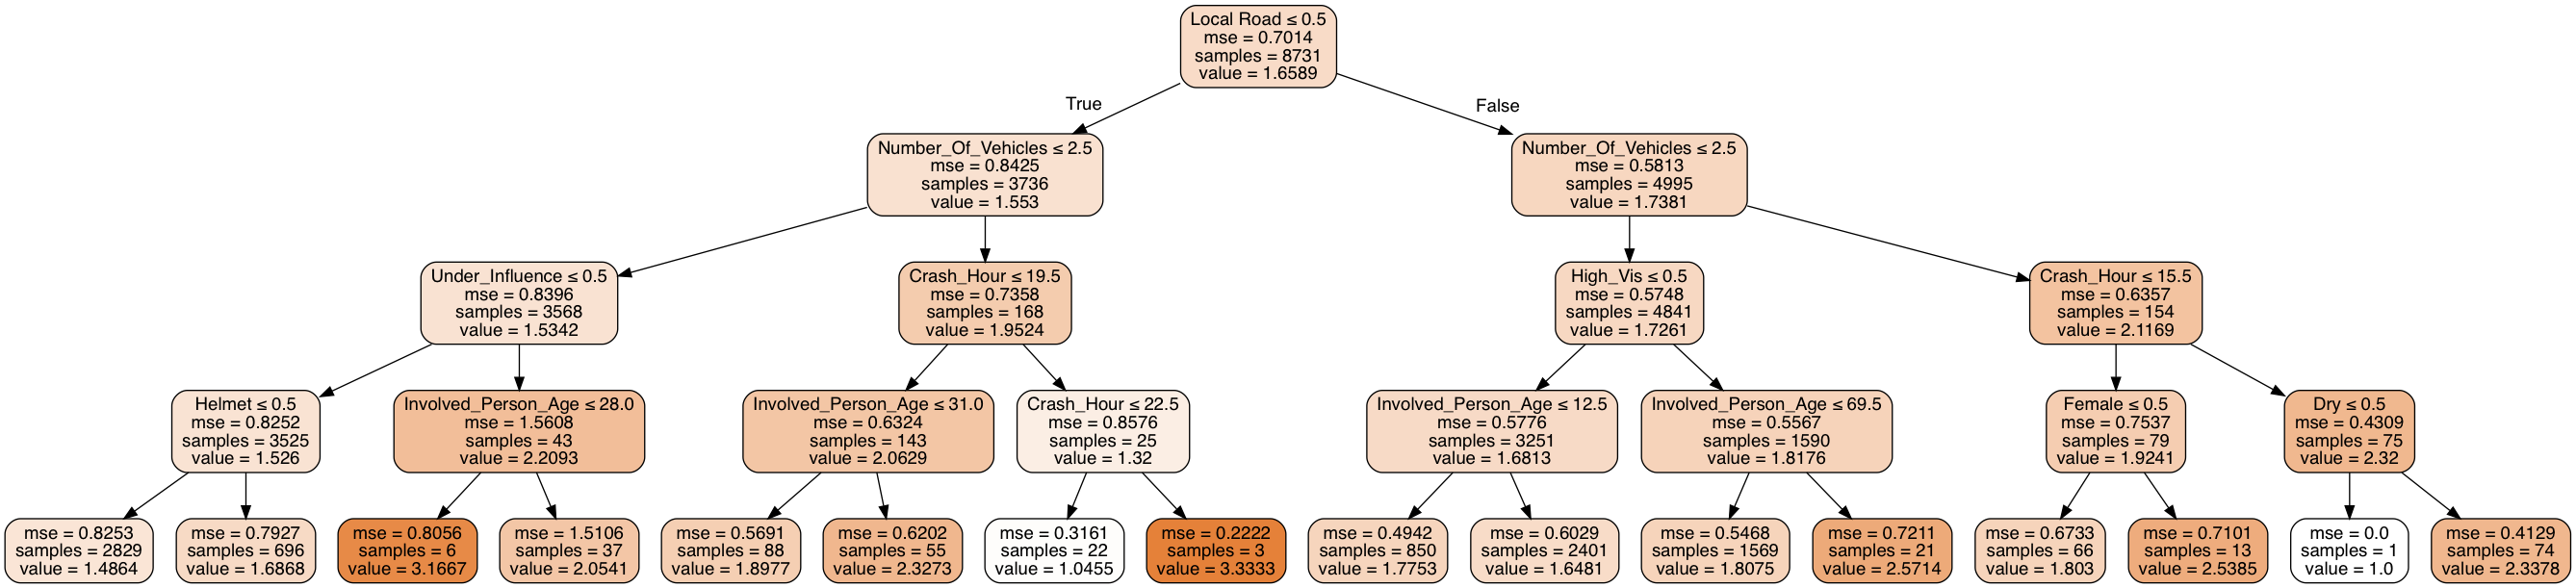

In [417]:
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 